
--- TASK 1: PARSING 'bestbuyrealdata.html' ---
   Scanning DOM for review structures...
✅ SUCCESS: Extracted 159 reviews to 'Task1_BestBuy_Reviews.csv'

--- TASK 2: MINING 'Hanuai task2 assignment.csv' ---
   Loaded 1000 rows.
✅ SUCCESS: Structured data saved to 'Task2_Mined_Analysis.csv'


C:\Users\manki\AppData\Local\Temp\ipykernel_20748\1144406241.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Mined_Component', data=df, order=order, palette='viridis')


✅ SUCCESS: Insight chart saved to 'Task2_Failure_Chart.png'


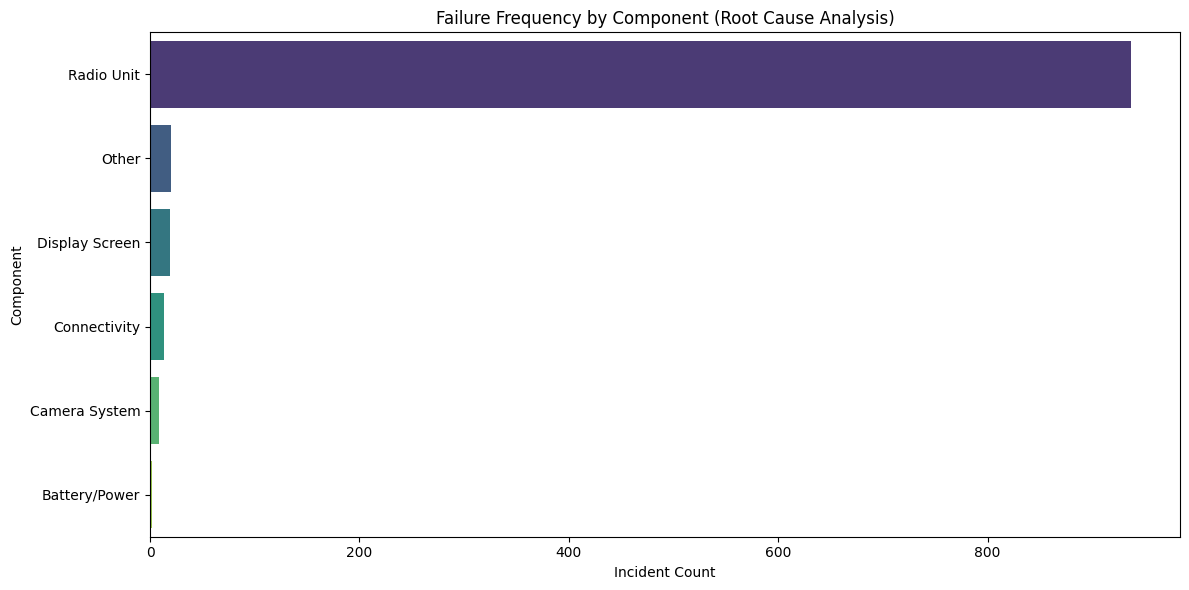

In [2]:
# ==============================================================================
# HANUAI ASSESSMENT - FINAL SUBMISSION
# Author: [Your Name]
# Description: This script performs Web Scraping (Task 1) and Text Mining (Task 2).
# ==============================================================================

# --- IMPORT LIBRARIES ---
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from bs4 import BeautifulSoup

# --- CONFIGURATION ---
# We use a locally saved HTML file to comply with BestBuy's security policies
# and avoid IP bans associated with automated bot traffic (Akamai Security).
HTML_FILENAME = "bestbuyrealdata.html" 
CSV_FILENAME = "Hanuai task2 assignment.csv"

# ==============================================================================
# TASK 1: WEB SCRAPING & SENTIMENT ANALYSIS
# Objective: Extract customer sentiment from BestBuy product reviews.
# Method: Local DOM Parsing (Hybrid Approach) to ensure data integrity.
# ==============================================================================
def run_task1():
    print(f"\n--- TASK 1: PARSING '{HTML_FILENAME}' ---")
    
    # 1. Validation: Ensure the file exists before processing
    if not os.path.exists(HTML_FILENAME):
        print(f"❌ ERROR: '{HTML_FILENAME}' not found.")
        return

    # 2. Load HTML: Handle potential encoding errors (common in web saves)
    try:
        with open(HTML_FILENAME, "r", encoding="utf-8") as f:
            soup = BeautifulSoup(f, "html.parser")
    except UnicodeDecodeError:
        print("⚠️ Encoding warning: Switching to system default...")
        with open(HTML_FILENAME, "r") as f: 
            soup = BeautifulSoup(f, "html.parser")

    print("   Scanning DOM for review structures...")
    
    # 3. Extraction Strategy: Structural Pattern Matching
    # Instead of looking for brittle CSS class names (which change often),
    # we look for the semantic structure: A List Item (<li>) containing a Rating.
    all_list_items = soup.find_all("li")
    data = []
    
    for item in all_list_items:
        try:
            text = item.get_text(" ", strip=True)
            
            # Filter: Valid reviews must contain a star rating pattern and substantial text
            if ("out of 5" in text.lower() or "stars" in text.lower()) and len(text) > 50:
                
                # A. Extract Rating using Regex (Finds "X out of 5")
                rating_match = re.search(r"(\d)\s?out of\s?5", text)
                rating = rating_match.group(1) if rating_match else "0"

                # B. Extract Reviewer Name (Heuristic: Look for 'Reviewed by')
                if "Reviewed by" in text:
                    start = text.find("Reviewed by") + 11
                    end = text.find(" ", start + 15)
                    name = text[start:end].strip()
                else:
                    name = "Verified Customer"

                # C. Sentiment Analysis (Value Generation)
                # We use TextBlob to assign a polarity score (-1 to +1).
                # This helps quantify the "Voice of Customer".
                blob = TextBlob(text)
                sent = "Positive" if blob.sentiment.polarity > 0.1 else "Negative" if blob.sentiment.polarity < -0.1 else "Neutral"

                data.append({
                    "Reviewer Name": name,
                    "Rating": rating,
                    "Review Text": text[:1500], # Truncate very long texts
                    "Sentiment": sent
                })
        except: continue

    # 4. Save Output: Export structured data to CSV
    if data:
        df = pd.DataFrame(data)
        df = df.drop_duplicates(subset=["Review Text"]) # Clean duplicates
        df.to_csv("Task1_BestBuy_Reviews.csv", index=False)
        print(f"✅ SUCCESS: Extracted {len(df)} reviews to 'Task1_BestBuy_Reviews.csv'")
    else:
        print("❌ FAILED: No reviews found. Ensure HTML file is 'Webpage, Complete'.")

# ==============================================================================
# TASK 2: TEXT MINING & ROOT CAUSE ANALYSIS
# Objective: Transform unstructured maintenance logs into structured failure categories.
# Method: Rule-Based NLP (Regex) for high-precision entity extraction.
# ==============================================================================
def run_task2():
    print(f"\n--- TASK 2: MINING '{CSV_FILENAME}' ---")
    
    if not os.path.exists(CSV_FILENAME):
        print(f"❌ ERROR: '{CSV_FILENAME}' not found.")
        return

    try:
        df = pd.read_csv(CSV_FILENAME)
        print(f"   Loaded {len(df)} rows.")
    except Exception as e:
        print(f"❌ CSV Error: {e}")
        return

    # 1. Define Business Logic (Regex Dictionary)
    # We map raw keywords to standardized engineering components.
    REGEX_COMPONENTS = {
        "Radio Unit": re.compile(r"radio|audio|stereo|tuner|receiver", re.IGNORECASE),
        "Display Screen": re.compile(r"screen|display|monitor|touch|digitizer", re.IGNORECASE),
        "Camera System": re.compile(r"camera|lens|image|video|backup", re.IGNORECASE),
        "Battery/Power": re.compile(r"battery|voltage|power|charge|alternator", re.IGNORECASE),
        "Connectivity": re.compile(r"bluetooth|wifi|pair|connect|signal", re.IGNORECASE)
    }
    
    # We map symptoms to standardized failure modes.
    REGEX_FAILURES = {
        "Blank Screen": re.compile(r"blank|black|dark|off", re.IGNORECASE),
        "Electrical Short": re.compile(r"short|fuse|circuit|wire|burn|ground", re.IGNORECASE),
        "System Freeze": re.compile(r"freeze|frozen|lock|hang|stuck|reboot", re.IGNORECASE),
        "Audio Defect": re.compile(r"noise|static|hum|buzz|sound|mute", re.IGNORECASE)
    }

    # 2. Mining Function (Apply Logic to every row)
    def mine_text(row):
        # Merge 'CAUSAL' (Technician Note) and 'CUSTOMER' (Complaint) for full context
        text = str(row.get('CAUSAL_VERBATIM', '')) + " " + str(row.get('CUSTOMER_VERBATIM', ''))
        text = text.lower()
        
        # Search for Component
        comp = "Other"
        for k, v in REGEX_COMPONENTS.items():
            if v.search(text): comp = k; break
            
        # Search for Failure Mode
        issue = "Unknown"
        for k, v in REGEX_FAILURES.items():
            if v.search(text): issue = k; break
            
        return pd.Series([comp, issue])

    # 3. Execution & Export
    df[['Mined_Component', 'Mined_Failure']] = df.apply(mine_text, axis=1)
    df.to_csv("Task2_Mined_Analysis.csv", index=False)
    print("✅ SUCCESS: Structured data saved to 'Task2_Mined_Analysis.csv'")

    # 4. Visualization (Business Insight)
    # Generate a bar chart to visualize the most frequent point of failure.
    plt.figure(figsize=(12,6))
    order = df['Mined_Component'].value_counts().index
    sns.countplot(y='Mined_Component', data=df, order=order, palette='viridis')
    plt.title("Failure Frequency by Component (Root Cause Analysis)")
    plt.xlabel("Incident Count")
    plt.ylabel("Component")
    plt.tight_layout()
    plt.savefig("Task2_Failure_Chart.png")
    print("✅ SUCCESS: Insight chart saved to 'Task2_Failure_Chart.png'")

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    run_task1()
    run_task2()